In [1]:
import pandas as pd
import scanpy as sc
from nheatmap import nhm
from scipy.stats import zscore

df = pd.read_csv('/hpc/projects/group.quake/doug/bulk_seq/sorted_Microglia_bulk.csv', index_col=0)

metadata_list = [col.split('_') for col in df.columns]

metadata_list = [x if len(x) == 4 else x + ['Unknown']*(4-len(x)) for x in metadata_list]

metadata_df = pd.DataFrame(metadata_list, columns=['celltype', 'Age', 'Region', 'Replicate','Extra'], index=df.columns)
metadata_df = metadata_df.drop('Extra',axis=1)


adata = sc.AnnData(X=df.T)  # Transpose since AnnData expects cells as rows, genes as columns
adata.obs = metadata_df

adata.var.index = df.index

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [2]:
new_ad = adata[(adata.obs.Age.isin(['22xM','3xM'])) & (adata.obs.Region.isin(['CB','HP']))]

CB_age = pd.read_excel('22CB_3CB_for_plot.xlsx').sort_values('log2FoldChange')
CB_HP = pd.read_excel('22cb_22hp_for_plot.xlsx').sort_values('log2FoldChange')

CB_HP = CB_HP[CB_HP.padj < 1e-10]
CB_age_up = CB_age[CB_age.padj < 1e-10]
CB_age_down = CB_age[CB_age.padj <0.01]

add_these_genes = ['Axl', 'C4b', 'Il2rg', 'Apoe', 'Ehd1', 'Fgr', 'Tnf', 'Atp1a3', 'Lgals3bp', 'Syp', 'Lgals3', 'Cd22', 'Ccl2', 'Ldlr', 'Cxcl16', 'B2m', 'Slc7a1', 'Ank2',
                   'Lilrb4a', 'Stat1', 'Ifi207','Ddx60', 'Tnfsf8', 'Gm4951','Fcrls','Cd22','Lpl','Apoe','Cybb','Itgax', 'Spp1', 'Hcar2']

what_about_these = [
    'Cxcl13', 'Ccl5', 'Vcam1', 'Cxcl10', 'Il1rn', 'Tnfsf8', 'Itgax', 'Apoe', 'Isg15', 'Cd74', 'Spp1', 'Fgr', 'Tnf', 'Rtp4', 'Nsg1', 'Lgals3', 'Cd22', 'Csf1', 'Stat1', 'Ccl2',
    'Cxcl16', 'Ccl3', 'Ccl4', 'Tap1', 'Gla', 'Plaur', 'Arfgef2', 'Tnfsf13b', 'Lpl', 'Cd72', 'Pdgfa', 'Axl', 'C4b', 'Il2rg', 'Apoe', 'Ehd1', 'Fgr', 'Tnf', 'Atp1a3', 'Lgals3bp',
    'Syp', 'Lgals3', 'Cd22', 'Ccl2', 'Ldlr', 'Cxcl16', 'B2m', 'Slc7a1', 'Ank2', 'Lilrb4a', 'Stat1', 'Ifi207', 'Ddx60', 'Tnfsf8', 'Gm4951'
]

subset_list = set(CB_age_up.tail(10).Gene.tolist() + add_these_genes + CB_age_down.head(10).Gene.tolist() + CB_HP.head(10).Gene.tolist()) - set(['Nid1','Syp','5330438l03Rik','Ildr2','Ank2','Vcam1'])
subset_list = [i for i in subset_list]

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/nheatmap/plot.py:345: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped_df = df.replace(tick_dictionary)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/nheatmap/plot.py:345: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped_df = df.replace(tick_dictionary)


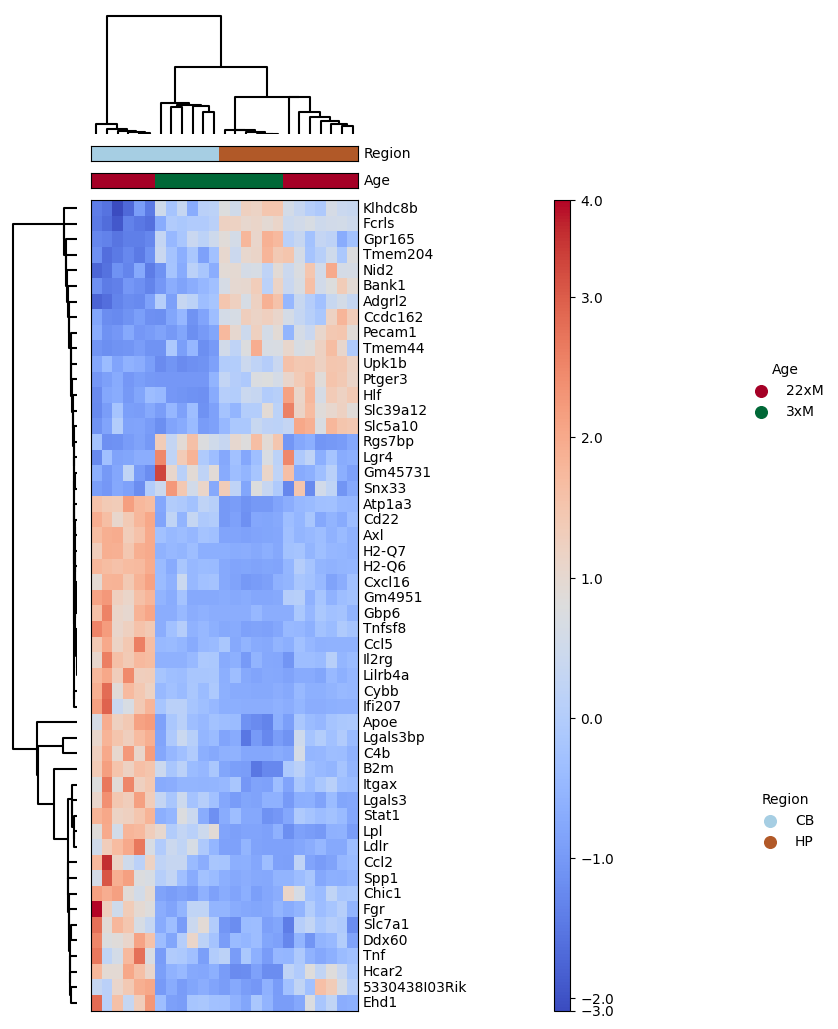

In [3]:
subset_genes = new_ad[:,subset_list]
counts_matrix = subset_genes.X
gene_names = subset_genes.var_names
cell_names = subset_genes.obs_names

# Create the DataFrame with obs_names as rows and var_names as columns
counts_df = pd.DataFrame(data=counts_matrix, index=cell_names, columns=gene_names)
zscored_df = counts_df.apply(zscore, axis=0)

subset_df = zscored_df

dfc = subset_genes.obs.loc[:,['Region','Age']]
dfr = subset_genes.obs.loc[:,['Region']]

cmaps={'Region':'Paired', 'Age':'RdYlGn'}

g = nhm(data=subset_df.T, dfc=dfc, figsize=(10, 13), linewidths=0, cmaps=cmaps, showxticks=False, cmapCenter='coolwarm')
g.hcluster(method='single', metric='cosine', optimal_ordering=False)
fig, plots = g.run()
fig.savefig('sorted_microglia_clusters.pdf', bbox_inches='tight')